In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import solve_ivp
import glob
import os
import numpy as np
import sys
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Verify data integrity.

Found 18 experiments. Generating consistency checks...


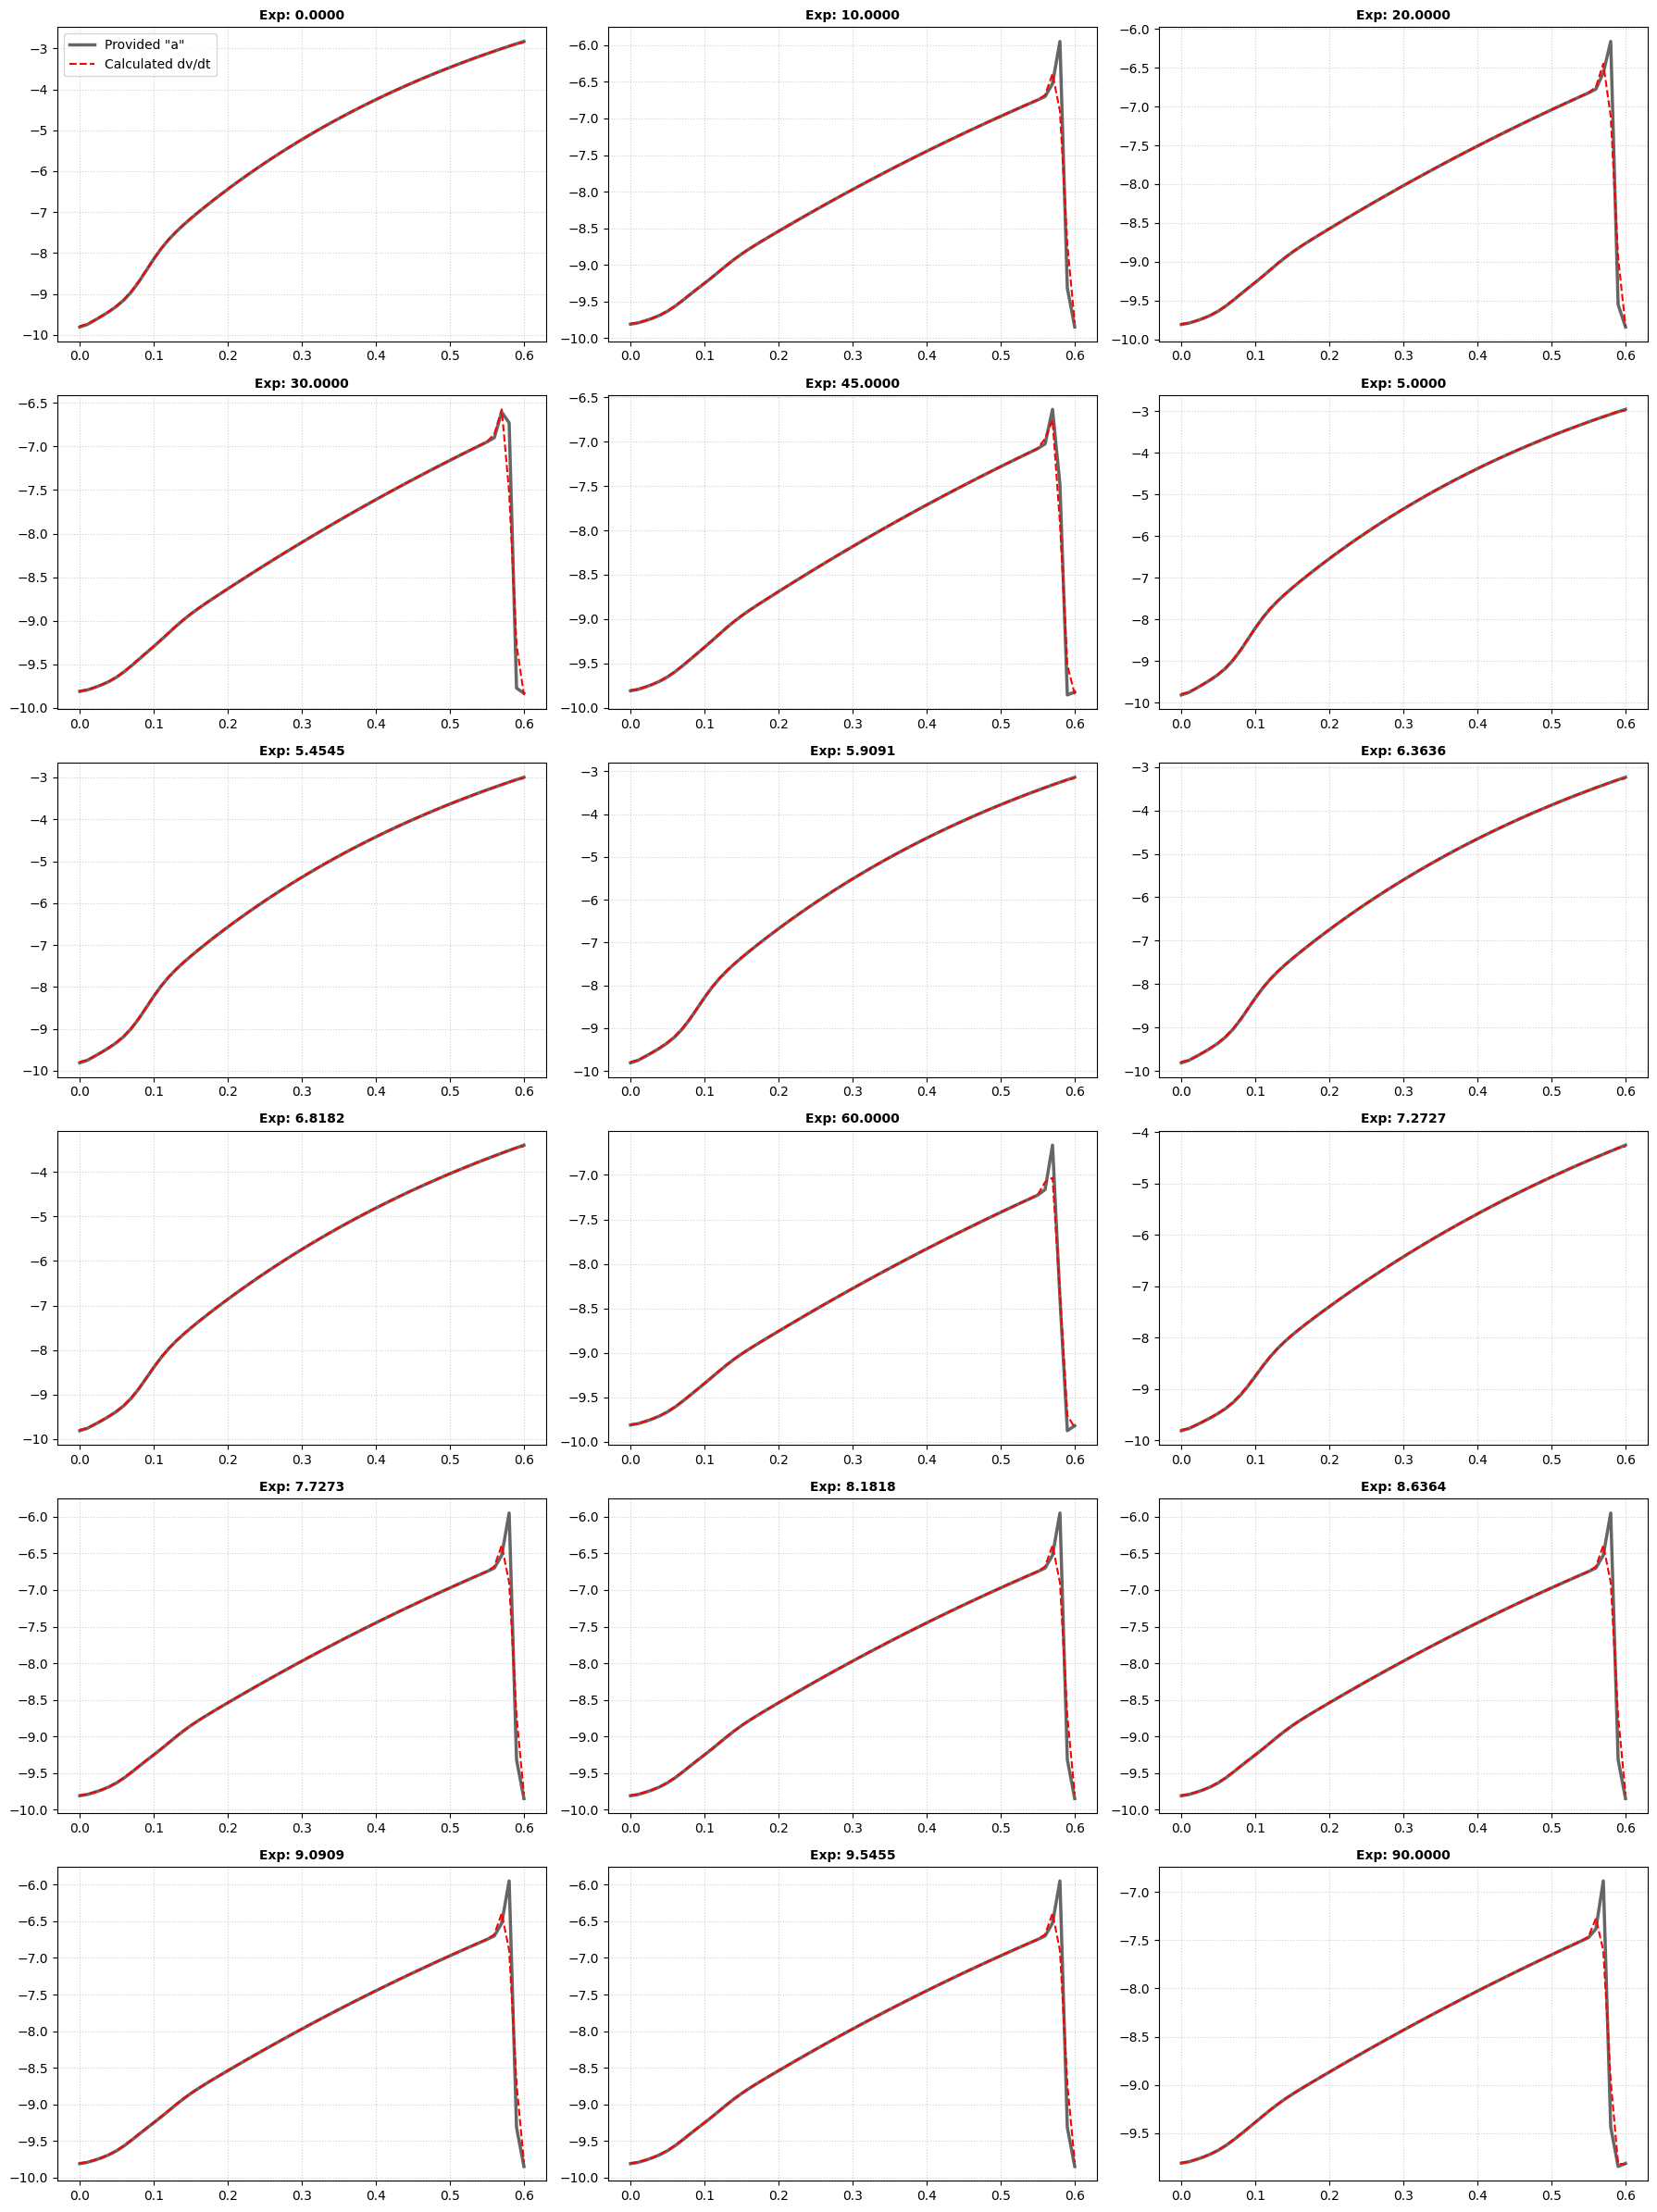

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import math

def verify_all_experiments(folder_path="./"):
    # 1. Find Files
    files = sorted(glob.glob(os.path.join(folder_path, "results_*.csv")))
    num_files = len(files)
    
    if num_files == 0:
        print("CRITICAL: No files found in the directory.")
        return

    print(f"Found {num_files} experiments. Generating consistency checks...")

    # 2. Setup Grid Layout (3 columns, dynamic rows)
    cols = 3
    rows = math.ceil(num_files / cols)
    
    # Adjust figure size based on number of rows
    fig, axes = plt.subplots(rows, cols, figsize=(18, 4 * rows))
    axes = axes.flatten() # Flatten to 1D array for easy looping

    for i, filepath in enumerate(files):
        ax = axes[i]
        
        try:
            # Load Data
            filename = os.path.basename(filepath)
            angle_label = filename.replace("results_", "").replace(".csv", "")
            
            df = pd.read_csv(filepath)
            df.columns = df.columns.str.strip()
            
            # Map columns
            col_map = {'t[s]': 't', 'v[m/s]': 'v', 'a[m/s^2]': 'a'}
            df.rename(columns={k:v for k,v in col_map.items() if k in df.columns}, inplace=True)
            
            # Extract
            t = df['t'].values
            v = df['v'].values
            a_fem = df['a'].values
            
            # --- THE CHECK ---
            # Calculate derivative of Velocity with respect to Time
            a_calc = np.gradient(v, t)
            
            # Plot
            ax.plot(t, a_fem, 'k-', linewidth=2.5, alpha=0.6, label='Provided "a"')
            ax.plot(t, a_calc, 'r--', linewidth=1.5, label='Calculated dv/dt')
            
            ax.set_title(f"Exp: {angle_label}", fontsize=10, fontweight='bold')
            ax.grid(True, linestyle=':', alpha=0.6)
            
            # Add Legend only to the first plot to avoid clutter
            if i == 0:
                ax.legend()
                
        except Exception as e:
            ax.text(0.5, 0.5, "Load Error", ha='center')
            print(f"Error reading {filename}: {e}")

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Run it
verify_all_experiments("./")

# Final model - JERK variant

Running on: cuda

--- LOADING DATA (Calculating Derivatives...) ---
-> Validation: 45.0°
Starting Training (Z, V, A, Jerk)...
Epoch 0 | Loss: 194.787781 | Jerk Loss: 1.188313
Epoch 1000 | Loss: 0.994914 | Jerk Loss: 0.006071
Epoch 2000 | Loss: 0.226353 | Jerk Loss: 0.001622
Epoch 3000 | Loss: 0.127392 | Jerk Loss: 0.000942
Epoch 4000 | Loss: 0.049338 | Jerk Loss: 0.000409
Epoch 5000 | Loss: 0.036399 | Jerk Loss: 0.000317
Epoch 6000 | Loss: 0.026871 | Jerk Loss: 0.000249
Epoch 7000 | Loss: 0.023255 | Jerk Loss: 0.000223
Epoch 8000 | Loss: 0.020304 | Jerk Loss: 0.000199
Epoch 9000 | Loss: 0.018779 | Jerk Loss: 0.000187


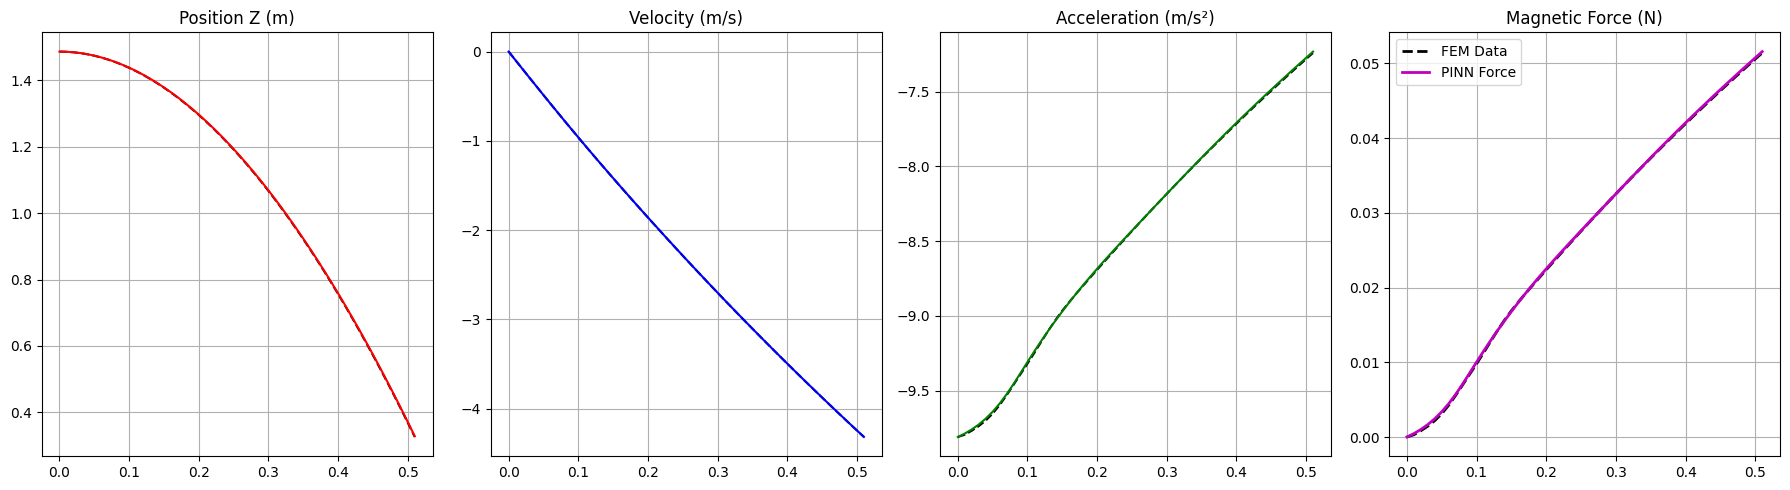

Saving model and scaler parameters...
Model saved to 'trained_surrogate_model.pth'


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
import sys

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

# ==========================================
# 1. DATA LOADER (Computes JERK)
# ==========================================
def load_fem_data_with_jerk(folder_path="./", validation_angle=45.0):
    print("\n--- LOADING DATA (Calculating Derivatives...) ---")
    
    files = sorted(glob.glob(os.path.join(folder_path, "results_*.csv")))
    if not files: sys.exit(1)
    
    data_list = []
    df_val = None
    
    for filepath in files:
        try:
            filename = os.path.basename(filepath)
            angle = float(filename.replace("results_", "").replace(".csv", ""))
            
            df = pd.read_csv(filepath)
            df.columns = df.columns.str.strip()
            col_map = {'t[s]': 't', 'z[m]': 'z', 'v[m/s]': 'v', 'a[m/s^2]': 'a', 'Fz[N]': 'Fz'}
            df.rename(columns={k:v for k,v in col_map.items() if k in df.columns}, inplace=True)
            df['gap'] = angle
            
            # Crop
            abs_a = df['a'].abs()
            min_drag_idx = abs_a.idxmin()
            cut_idx = max(0, min_drag_idx - 5)
            df_cropped = df.iloc[:cut_idx].copy()
            if len(df_cropped) < 10: continue

            # --- COMPUTE JERK (da/dt) ---
            # We use numpy gradient. 
            # Ideally, we calculate this BEFORE normalization.
            a_vals = df_cropped['a'].values
            t_vals = df_cropped['t'].values
            j_vals = np.gradient(a_vals, t_vals)
            
            # Optional: Simple moving average to smooth numerical noise in Jerk
            # j_vals = pd.Series(j_vals).rolling(window=3, center=True).mean().fillna(method='bfill').fillna(method='ffill').values
            
            df_cropped['j'] = j_vals

            if np.isclose(angle, validation_angle, atol=0.01):
                df_val = df_cropped
                print(f"-> Validation: {angle}°")
            else:
                data_list.append(df_cropped)
                
        except Exception as e:
            print(f"Skipping {filename}: {e}")

    df_train = pd.concat(data_list, ignore_index=True)
    return df_train, df_val

# Load
df_train, df_test_truth = load_fem_data_with_jerk(folder_path="./", validation_angle=45.0)

# ==========================================
# 2. SCALER (Includes Jerk)
# ==========================================
class RobustScaler:
    def __init__(self, df):
        self.t_max = df['t'].max()
        self.gap_max = df['gap'].max()
        self.z_start = df['z'].max() 
        self.v_max = df['v'].abs().max()
        self.a_max = df['a'].abs().max()
        # Scale Jerk by its max magnitude
        self.j_max = df['j'].abs().max()
        
    def transform_inputs(self, t, gap):
        t_n = t / self.t_max
        gap_n = gap / self.gap_max 
        return t_n, gap_n

scaler = RobustScaler(df_train)

t_np = df_train['t'].values
gap_np = df_train['gap'].values
z_np = df_train['z'].values
v_np = df_train['v'].values
a_np = df_train['a'].values
j_np = df_train['j'].values 

t_norm, gap_norm = scaler.transform_inputs(t_np, gap_np)

# TARGETS
Y_z = torch.tensor(z_np / scaler.z_start, dtype=torch.float32, device=device).view(-1, 1)
Y_v = torch.tensor(v_np / scaler.v_max, dtype=torch.float32, device=device).view(-1, 1)
Y_a = torch.tensor(a_np / scaler.a_max, dtype=torch.float32, device=device).view(-1, 1)
Y_j = torch.tensor(j_np / scaler.j_max, dtype=torch.float32, device=device).view(-1, 1) 

X_t = torch.tensor(t_norm, dtype=torch.float32, device=device).view(-1, 1)
X_gap = torch.tensor(gap_norm, dtype=torch.float32, device=device).view(-1, 1)

# ==========================================
# 3. MODEL (Braking Ansatz)
# ==========================================
class SurrogateModel(nn.Module):
    def __init__(self, scaler_z_start, scaler_t_max):
        super().__init__()
        
        g_real = 9.81
        self.g_norm = g_real * (scaler_t_max**2 / scaler_z_start)
        self.register_buffer('gravity_term', torch.tensor(self.g_norm, dtype=torch.float32))

        # Standard MLP, high capacity
        self.net = nn.Sequential(
            nn.Linear(2, 64), 
            nn.Tanh(),
            nn.Linear(64, 64), 
            nn.Tanh(),
            nn.Linear(64, 64), 
            nn.Tanh(),
            nn.Linear(64, 1),
            nn.Softplus() # Braking is always positive
        )
        
    def forward(self, t, gap):
        x = torch.cat([t, gap], dim=1)
        braking_mag = self.net(x)
        
        # Physics Ansatz (Start at 1.0, substract gravity, add braking)
        # z = 1.0 - (0.5gt^2 - t^3*braking)
        dist_gravity = 0.5 * self.gravity_term * (t ** 2)
        dist_braking = (t ** 3) * braking_mag
        
        return 1.0 - (dist_gravity - dist_braking)

model = SurrogateModel(scaler.z_start, scaler.t_max).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.5)

# ==========================================
# 4. TRAINING (The 3rd Derivative Loop)
# ==========================================
print("Starting Training (Z, V, A, Jerk)...")
epochs = 10000

for epoch in range(epochs):
    optimizer.zero_grad()
    
    t_in = X_t.clone().requires_grad_(True)
    gap_in = X_gap.clone()
    
    # 1. Position
    z_pred_norm = model(t_in, gap_in)
    
    # 2. Velocity
    dz = torch.autograd.grad(z_pred_norm, t_in, torch.ones_like(z_pred_norm), create_graph=True)[0]
    v_factor = (scaler.z_start / scaler.t_max) / scaler.v_max
    v_pred_norm = dz * v_factor
    
    # 3. Acceleration
    dv = torch.autograd.grad(v_pred_norm, t_in, torch.ones_like(v_pred_norm), create_graph=True)[0]
    a_factor = (scaler.v_max / scaler.t_max) / scaler.a_max
    a_pred_norm = dv * a_factor
    
    # 4. JERK (3rd Derivative)
    # Derivative of normalized acceleration w.r.t normalized time
    da = torch.autograd.grad(a_pred_norm, t_in, torch.ones_like(a_pred_norm), create_graph=True)[0]
    j_factor = (scaler.a_max / scaler.t_max) / scaler.j_max
    j_pred_norm = da * j_factor
    
    # --- LOSSES ---
    loss_z = torch.mean((z_pred_norm - Y_z)**2)
    loss_v = torch.mean((v_pred_norm - Y_v)**2)
    loss_a = torch.mean((a_pred_norm - Y_a)**2)
    loss_j = torch.mean((j_pred_norm - Y_j)**2) # The Constraint
    
    # Weighting Strategy:
    # A and Jerk define the "physics shape".
    # Z and V define the "boundary conditions".
    # If the Jerk loss is too high, the curve will wiggle.
    total_loss = 1.0*loss_z + 10.0*loss_v + 100.0*loss_a + 90.0*loss_j
    
    total_loss.backward()
    optimizer.step()
    scheduler.step()
    
    if epoch % 1000 == 0:
        print(f"Epoch {epoch} | Loss: {total_loss.item():.6f} | Jerk Loss: {loss_j.item():.6f}")
        


# ==========================================
# 5. VALIDATION
# ==========================================
if df_test_truth is not None:
    t_vals = df_test_truth['t'].values
    z_true = df_test_truth['z'].values
    v_true = df_test_truth['v'].values
    a_true = df_test_truth['a'].values
    F_true = df_test_truth['Fz'].abs().values
    val_gap = df_test_truth['gap'].iloc[0]

    # Mass Estimate
    mid = len(a_true)//2
    braking_accel = 9.81 + a_true[mid]
    REAL_MASS = F_true[mid] / braking_accel if braking_accel > 0.1 else 0.02

    # Inference
    t_in, gap_in = scaler.transform_inputs(t_vals, np.full_like(t_vals, val_gap))
    t_tens = torch.tensor(t_in, dtype=torch.float32, device=device).view(-1,1).requires_grad_(True)
    gap_tens = torch.tensor(gap_in, dtype=torch.float32, device=device).view(-1,1)

    z_out = model(t_tens, gap_tens)
    dz = torch.autograd.grad(z_out, t_tens, torch.ones_like(z_out), create_graph=True)[0]
    dv = torch.autograd.grad(dz, t_tens, torch.ones_like(dz))[0]

    z_pred = z_out.detach().cpu().numpy().flatten() * scaler.z_start
    v_pred = dz.detach().cpu().numpy().flatten() * (scaler.z_start / scaler.t_max)
    a_pred = dv.detach().cpu().numpy().flatten() * (scaler.z_start / scaler.t_max**2)

    F_pred = REAL_MASS * (9.81 + a_pred)

    # Plot
    plt.figure(figsize=(18, 5))
    
    plt.subplot(1,4,1)
    plt.plot(t_vals, z_true, 'k--', label='FEM')
    plt.plot(t_vals, z_pred, 'r', label='PINN')
    plt.title(f"Position Z (m)")
    plt.grid(True)
    
    plt.subplot(1,4,2)
    plt.plot(t_vals, v_true, 'k--', label='FEM')
    plt.plot(t_vals, v_pred, 'b', label='PINN')
    plt.title("Velocity (m/s)")
    plt.grid(True)
    
    plt.subplot(1,4,3)
    plt.plot(t_vals, a_true, 'k--', label='FEM')
    plt.plot(t_vals, a_pred, 'g', label='PINN')
    plt.title("Acceleration (m/s²)")
    plt.grid(True)
    
    plt.subplot(1,4,4)
    plt.plot(t_vals, F_true, 'k--', linewidth=2, label='FEM Data')
    plt.plot(t_vals, F_pred, 'm', linewidth=2, label='PINN Force')
    plt.title("Magnetic Force (N)")
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
# ==========================================
# 6. SAVE MODEL
# ==========================================
print("Saving model and scaler parameters...")

# Create a dictionary containing weights + scaler info
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    # Save the scaler parameters 
    'scaler_params': {
        't_max': scaler.t_max,
        'gap_max': scaler.gap_max,
        'z_start': scaler.z_start,
        'v_max': scaler.v_max,
        'a_max': scaler.a_max,
        'j_max': scaler.j_max
    }
}

torch.save(checkpoint, "trained_surrogate_model.pth")
print("Model saved to 'trained_surrogate_model.pth'")

# Verification - validation on new data

Loading: ./results_95.0000.csv


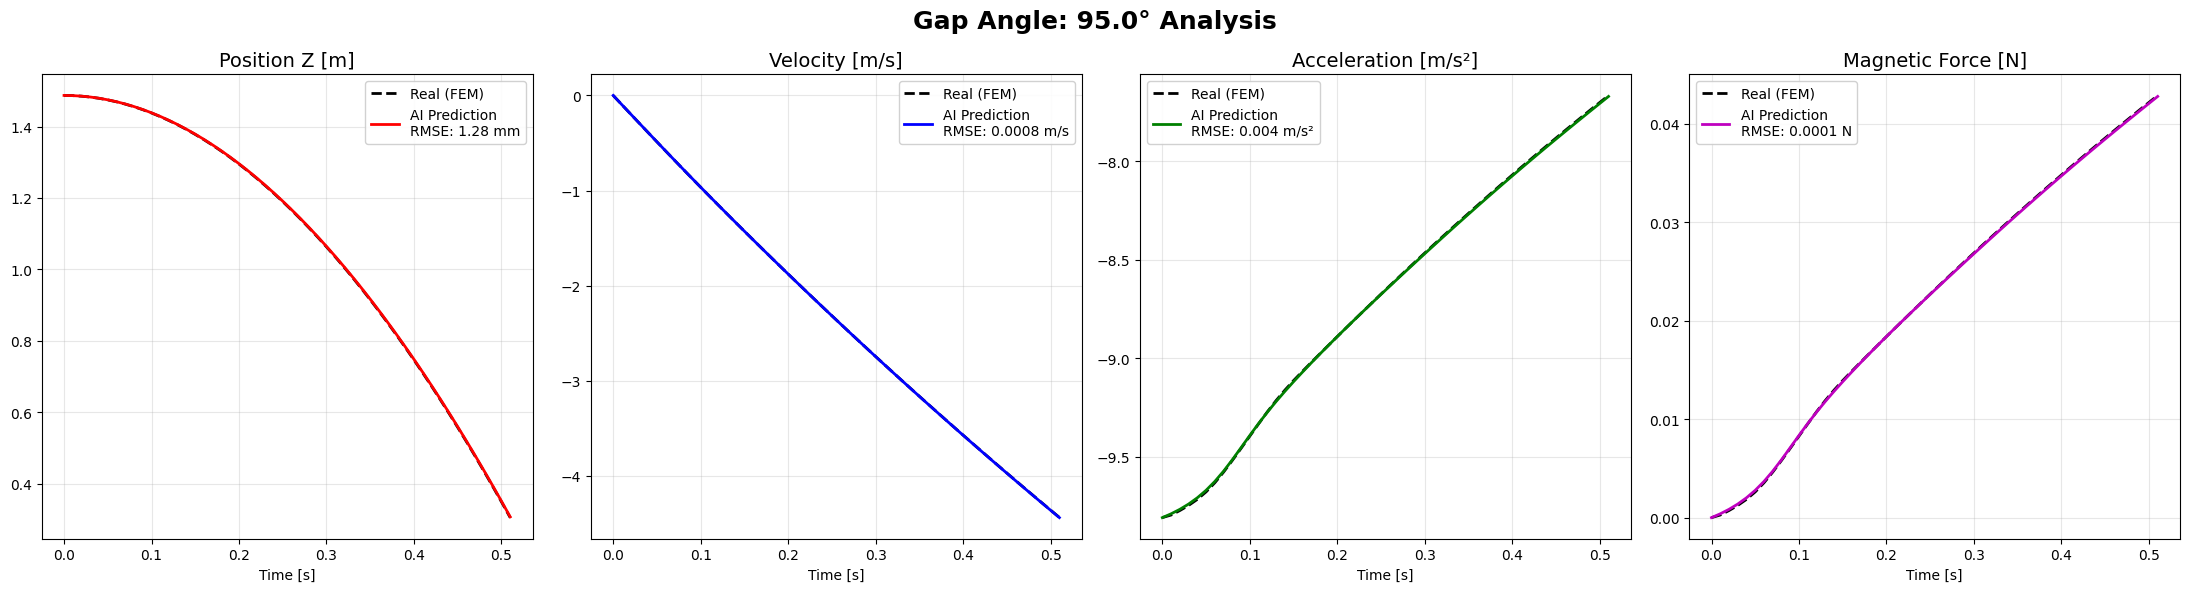

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==========================================
# 1. DEFINE THE MODEL CLASS
# ==========================================
class SurrogateModel(nn.Module):
    def __init__(self, scaler_z_start, scaler_t_max):
        super().__init__()
        g_real = 9.81
        self.g_norm = g_real * (scaler_t_max**2 / scaler_z_start)
        self.register_buffer('gravity_term', torch.tensor(self.g_norm, dtype=torch.float32))

        self.net = nn.Sequential(
            nn.Linear(2, 64), 
            nn.Tanh(),
            nn.Linear(64, 64), 
            nn.Tanh(),
            nn.Linear(64, 64), 
            nn.Tanh(),
            nn.Linear(64, 1),
            nn.Softplus()
        )
        
    def forward(self, t, gap):
        x = torch.cat([t, gap], dim=1)
        braking_mag = self.net(x)
        dist_gravity = 0.5 * self.gravity_term * (t ** 2)
        dist_braking = (t ** 3) * braking_mag
        return 1.0 - (dist_gravity - dist_braking)

# ==========================================
# 2. LOAD SAVED MODEL & SCALERS
# ==========================================
def load_trained_model(path="trained_surrogate_model.pth"):
    if not os.path.exists(path):
        print(f"Error: {path} not found. Please train and save the model first.")
        return None, None

    # weights_only=False fixes the unpickling error for numpy scalars
    checkpoint = torch.load(path, map_location=device, weights_only=False)
    params = checkpoint['scaler_params']
    
    model = SurrogateModel(params['z_start'], params['t_max']).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    return model, params

# ==========================================
# 3. LOAD A NEW SIMULATION CSV
# ==========================================
def load_single_csv(filepath):
    print(f"Loading: {filepath}")
    df = pd.read_csv(filepath)
    df.columns = df.columns.str.strip()
    
    col_map = {'t[s]': 't', 'z[m]': 'z', 'v[m/s]': 'v', 'a[m/s^2]': 'a', 'Fz[N]': 'Fz'}
    df.rename(columns={k:v for k,v in col_map.items() if k in df.columns}, inplace=True)
    
    filename = os.path.basename(filepath)
    try:
        angle_str = filename.replace("results_", "").replace(".csv", "")
        df['gap'] = float(angle_str)
    except:
        print("Warning: Could not parse angle from filename. Defaulting to 45.0")
        df['gap'] = 45.0
        
    return df

# ==========================================
# 4. PREDICT, CALCULATE ERROR, AND PLOT
# ==========================================
def predict_and_compare(model, params, csv_path):
    # 1. Load Data
    df = load_single_csv(csv_path)
    
    # Crop
    cut_idx = df['a'].abs().idxmin() - 5
    if cut_idx > 10:
        df = df.iloc[:cut_idx]

    t_vals = df['t'].values
    gap_val = df['gap'].iloc[0]
    
    # 2. Normalize
    t_norm = t_vals / params['t_max']
    gap_norm = np.full_like(t_vals, gap_val) / params['gap_max']
    
    t_tens = torch.tensor(t_norm, dtype=torch.float32, device=device).view(-1,1).requires_grad_(True)
    gap_tens = torch.tensor(gap_norm, dtype=torch.float32, device=device).view(-1,1)
    
    # 3. Inference
    z_out_norm = model(t_tens, gap_tens)
    dz = torch.autograd.grad(z_out_norm, t_tens, torch.ones_like(z_out_norm), create_graph=True)[0]
    dv = torch.autograd.grad(dz, t_tens, torch.ones_like(dz), create_graph=False)[0]
    
    # 4. Denormalize
    z_pred = z_out_norm.detach().cpu().numpy().flatten() * params['z_start']
    v_pred = dz.detach().cpu().numpy().flatten() * (params['z_start'] / params['t_max'])
    a_pred = dv.detach().cpu().numpy().flatten() * (params['z_start'] / (params['t_max']**2))

    # Force Calculation (Physics)
    mid_idx = len(df) // 2
    a_real_mid = df['a'].iloc[mid_idx]
    F_real_mid = df['Fz'].abs().iloc[mid_idx]
    estimated_mass = F_real_mid / (9.81 + a_real_mid) if (9.81+a_real_mid) > 0.1 else 0.02
    F_pred = estimated_mass * (9.81 + a_pred)
    
    # 5. Metrics
    z_true = df['z'].values
    v_true = df['v'].values
    a_true = df['a'].values
    F_true = df['Fz'].abs().values

    mse_z = np.mean((z_true - z_pred)**2)
    mse_v = np.mean((v_true - v_pred)**2)
    mse_a = np.mean((a_true - a_pred)**2)
    mse_f = np.mean((F_true - F_pred)**2)

    rmse_z = np.sqrt(mse_z)
    rmse_v = np.sqrt(mse_v)
    rmse_a = np.sqrt(mse_a)
    rmse_f = np.sqrt(mse_f)

    # 6. PLOTTING (The "Cool" Version)
    # We make the figure slightly wider to accommodate the legends
    fig, axes = plt.subplots(1, 4, figsize=(22, 6))
    fig.suptitle(f"Gap Angle: {gap_val}° Analysis", fontsize=18, weight='bold')

    # --- Position (Z) ---
    axes[0].plot(t_vals, z_true, 'k--', linewidth=2, label='Real (FEM)')
    # Convert RMSE to mm for the label
    lbl_z = f'AI Prediction\nRMSE: {rmse_z*1000:.2f} mm'
    axes[0].plot(t_vals, z_pred, 'r-', linewidth=2, label=lbl_z)
    
    axes[0].set_title("Position Z [m]", fontsize=14)
    axes[0].set_xlabel("Time [s]")
    axes[0].legend(loc='best', fontsize=10, frameon=True, fancybox=True, framealpha=0.9)
    axes[0].grid(True, alpha=0.3)

    # --- Velocity (V) ---
    axes[1].plot(t_vals, v_true, 'k--', linewidth=2, label='Real (FEM)')
    lbl_v = f'AI Prediction\nRMSE: {rmse_v:.4f} m/s'
    axes[1].plot(t_vals, v_pred, 'b-', linewidth=2, label=lbl_v)
    
    axes[1].set_title("Velocity [m/s]", fontsize=14)
    axes[1].set_xlabel("Time [s]")
    axes[1].legend(loc='best', fontsize=10, frameon=True, fancybox=True, framealpha=0.9)
    axes[1].grid(True, alpha=0.3)

    # --- Acceleration (A) ---
    axes[2].plot(t_vals, a_true, 'k--', linewidth=2, label='Real (FEM)')
    lbl_a = f'AI Prediction\nRMSE: {rmse_a:.3f} m/s²'
    axes[2].plot(t_vals, a_pred, 'g-', linewidth=2, label=lbl_a)
    
    axes[2].set_title("Acceleration [m/s²]", fontsize=14)
    axes[2].set_xlabel("Time [s]")
    axes[2].legend(loc='best', fontsize=10, frameon=True, fancybox=True, framealpha=0.9)
    axes[2].grid(True, alpha=0.3)

    # --- Force (F) ---
    axes[3].plot(t_vals, F_true, 'k--', linewidth=2, label='Real (FEM)')
    # Use 4 decimals for Force to capture small errors
    lbl_f = f'AI Prediction\nRMSE: {rmse_f:.4f} N'
    axes[3].plot(t_vals, F_pred, 'm-', linewidth=2, label=lbl_f)
    
    axes[3].set_title("Magnetic Force [N]", fontsize=14)
    axes[3].set_xlabel("Time [s]")
    axes[3].legend(loc='best', fontsize=10, frameon=True, fancybox=True, framealpha=0.9)
    axes[3].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Run it
model, scaler_params = load_trained_model("trained_surrogate_model.pth")
test_file = "./results_95.0000.csv" 

if model and os.path.exists(test_file):
    predict_and_compare(model, scaler_params, test_file)

Loading: ./results_120.0000.csv


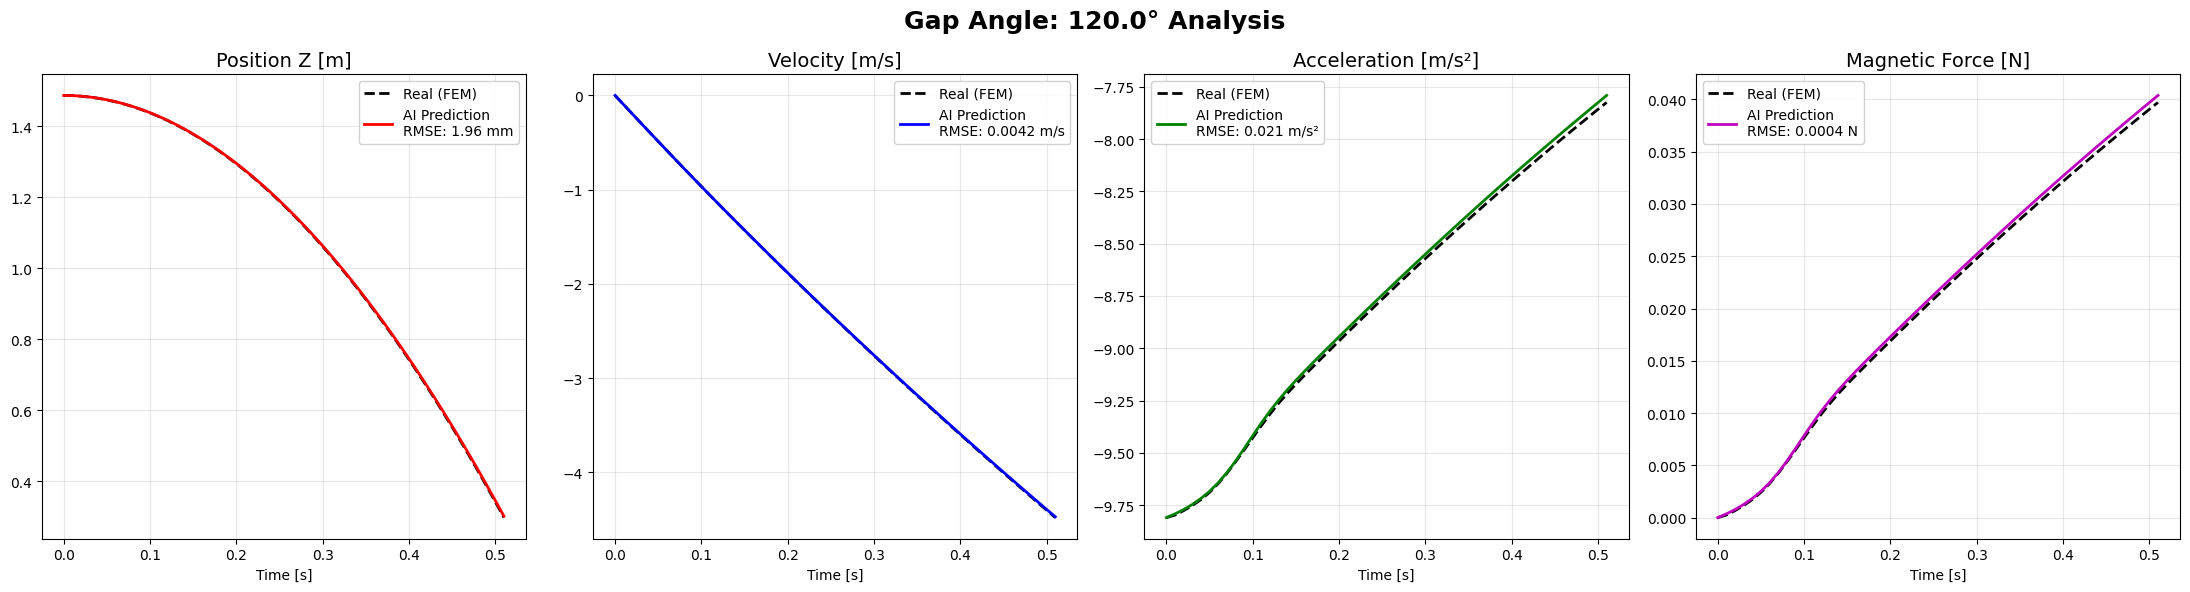

In [ ]:
# ==========================================
# 5. RUN
# ==========================================
# 1. Load model
model, scaler_params = load_trained_model("trained_surrogate_model.pth")

# 2. Specify the new file you want to test
# Replace this with any filename (e.g., results_30.0.csv)
test_file = "./results_120.0000.csv" 

if model and os.path.exists(test_file):
    predict_and_compare(model, scaler_params, test_file)
else:
    print("Please check that the model file and the CSV file exist.")

Loading: ./results_45.0000.csv


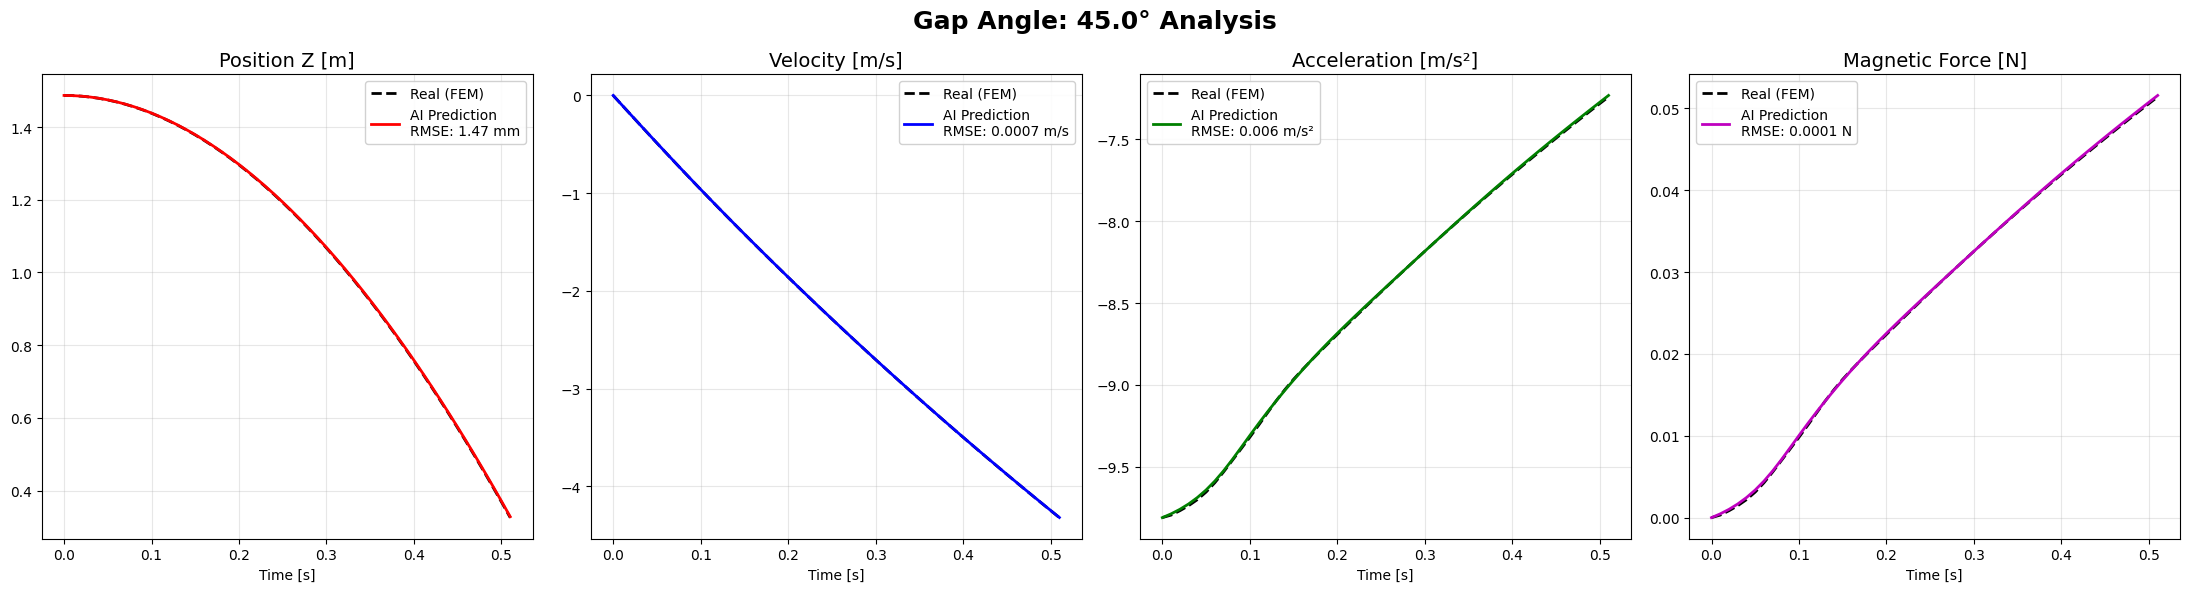

In [ ]:
model, scaler_params = load_trained_model("trained_surrogate_model.pth")
test_file = "./results_45.0000.csv" 

if model and os.path.exists(test_file):
    predict_and_compare(model, scaler_params, test_file)

Loading: ./results_9.5455.csv


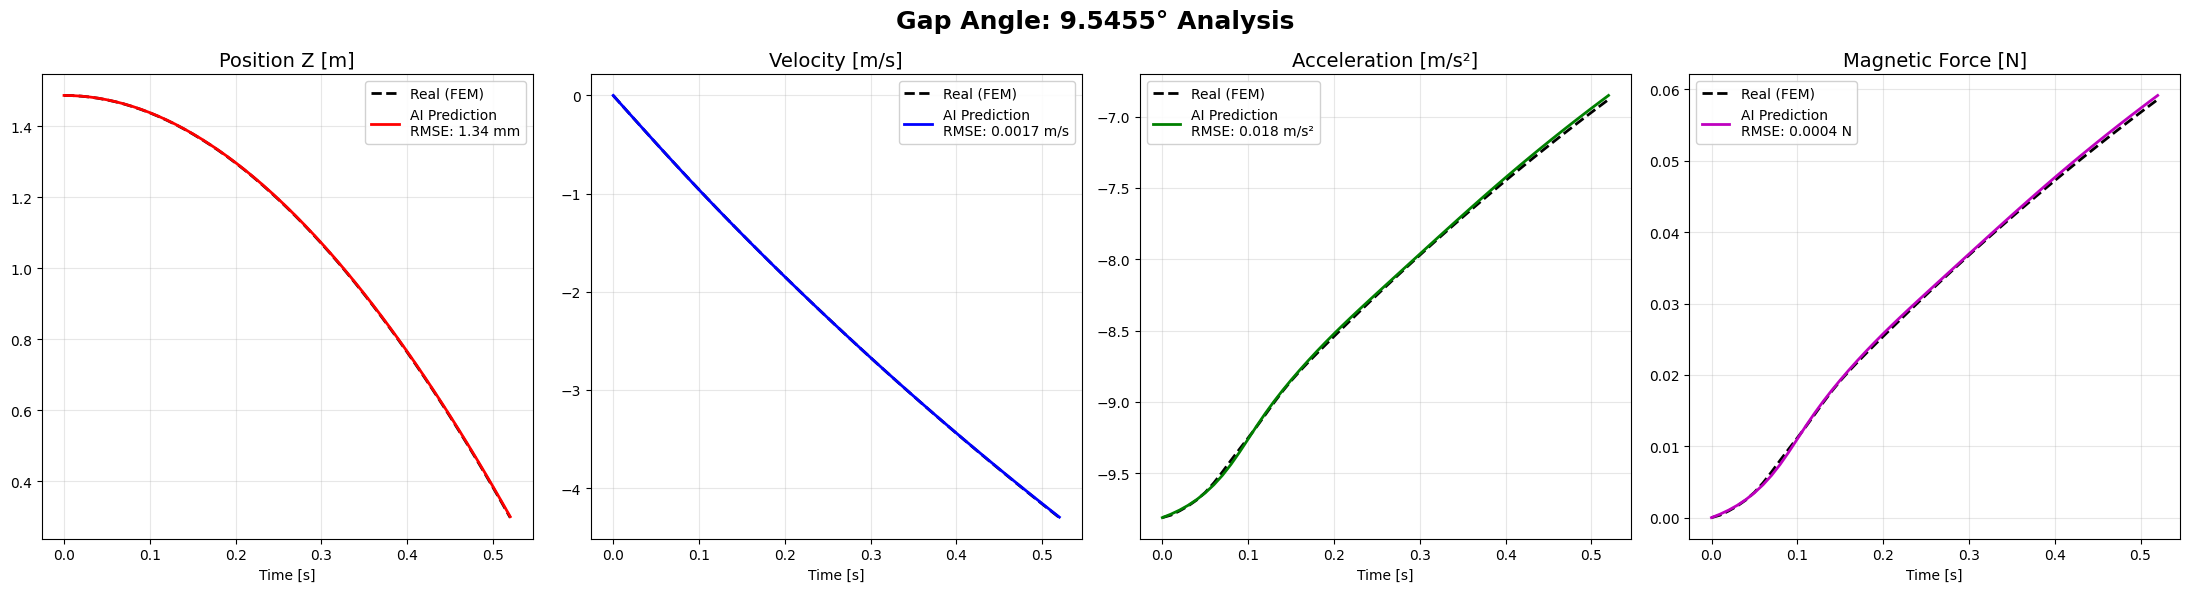

In [ ]:
model, scaler_params = load_trained_model("trained_surrogate_model.pth")
test_file = "./results_9.5455.csv" 

if model and os.path.exists(test_file):
    predict_and_compare(model, scaler_params, test_file)